In [1]:
!pip install --quiet librosa soundfile praat-parselmouth openpyxl tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 109.7 MB/s eta 0:00:00


In [2]:
# ---------- Mount Google Drive ----------
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import librosa
import librosa.display
import parselmouth
from tqdm import tqdm
import matplotlib.pyplot as plt


# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Activation, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [4]:
RAVDESS = "/content/drive/MyDrive/NLP Datasets/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
CREMA = "/content/drive/MyDrive/NLP Datasets/cremad/AudioWAV/"
TESS = "/content/drive/MyDrive/NLP Datasets/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/"
# Output paths
FEATURE_EXCEL = "/content/drive/MyDrive/speech_features.xlsx"
MODEL_SAVE_PATH = "/content/drive/MyDrive/emotion_recognition_model.h5"
# ---------- Dataset reading (RAVDESS, CREMA-D, TESS) ----------

def load_ravdess(path):
    emotion_map = {'01': 'neutral', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'scared', '07': 'disgust'}
    rows = []
    for actor in sorted(os.listdir(path)):
        actor_dir = os.path.join(path, actor)
        if not os.path.isdir(actor_dir):
            continue
        for fname in os.listdir(actor_dir):
            if not fname.lower().endswith('.wav'):
                continue
            part = fname.split('.')[0]
            code = part.split('-')[2]
            if code in emotion_map:
                gender_code = int(part.split('-')[6])
                gender = 'F' if gender_code % 2 == 0 else 'M'
                rows.append({'path': os.path.join(actor_dir, fname), 'sex': gender, 'emotion': emotion_map[code]})
    return pd.DataFrame(rows)


def load_crema(path):
    emotion_map = {'HAP': 'happy', 'NEU': 'neutral', 'SAD': 'sad', 'ANG': 'angry', 'FEA': 'scared', 'DIS': 'disgust'}
    female_list = set([
        '1002','1003','1004','1006','1007','1008','1009','1010','1012','1013','1018','1020','1021','1024','1025',
        '1028','1029','1030','1037','1043','1046','1047','1049','1052','1053','1054','1055','1056','1058','1060',
        '1061','1063','1072','1073','1074','1075','1076','1078','1079','1082','1084','1089','1091'
    ])
    rows = []
    for fname in sorted(os.listdir(path)):
        if not fname.lower().endswith('.wav'):
            continue
        parts = fname.split('_')
        if len(parts) < 3:
            continue
        key = parts[2]
        if key in emotion_map:
            id_ = parts[0]
            gender = 'F' if id_ in female_list else 'M'
            rows.append({'path': os.path.join(path, fname), 'sex': gender, 'emotion': emotion_map[key]})
    return pd.DataFrame(rows)


def load_tess(path):
    # TESS has subfolders for actors; all female
    emotion_map = {
        'happy':'happy','neutral':'neutral','sad':'sad','Sad':'sad','angry':'angry','fear':'scared','disgust':'disgust'
    }
    rows = []
    for actor_dir in sorted(os.listdir(path)):
        full_dir = os.path.join(path, actor_dir)
        if not os.path.isdir(full_dir):
            continue
        for fname in sorted(os.listdir(full_dir)):
            if not fname.lower().endswith('.wav'):
                continue
            base = fname.split('.')[0]
            key = base.split('_')[-1]
            if key.endswith('0'):
                key = key[:-1]
            if key in emotion_map:
                rows.append({'path': os.path.join(full_dir, fname), 'sex': 'F', 'emotion': emotion_map[key]})
    return pd.DataFrame(rows)

# load datasets
ravdess_df = load_ravdess(RAVDESS)
crema_df = load_crema(CREMA)
tess_df = load_tess(TESS)

# combine
df = pd.concat([ravdess_df, crema_df, tess_df], ignore_index=True)
print('Total samples loaded:', len(df))
print(df['emotion'].value_counts())


Total samples loaded: 10898
emotion
scared     1863
disgust    1863
happy      1863
angry      1863
sad        1863
neutral    1583
Name: count, dtype: int64


In [5]:
# ---------- Feature extraction functions ----------

FRAME_LENGTH = 2048
HOP_LENGTH = 512
N_MFCC = 13


def extract_features(path, n_mfcc=N_MFCC, fmin=50.0, fmax=500.0):
    """Return a dict of features for a single audio file."""
    try:
        y, sr = librosa.load(path, sr=None, mono=True)
    except Exception as e:
        print('Load error', path, e)
        return None

    # Basic
    duration = len(y) / sr
    mean_amp = float(np.mean(np.abs(y)))
    peak_amp = float(np.max(np.abs(y)))

    # RMS
    rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    rms_mean = float(np.mean(rms)) if len(rms) else 0.0
    rms_std = float(np.std(rms)) if len(rms) else 0.0

    # Intensity (dB)
    intensity_db_mean = float(np.mean(librosa.amplitude_to_db(np.maximum(rms, 1e-9))))

    # Tempo
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    try:
        tempo_val = float(librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0])
    except:
        tempo_val = 0.0

    # ZCR
    zcr = librosa.feature.zero_crossing_rate(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
    zcr_mean = float(np.mean(zcr))
    zcr_std = float(np.std(zcr))

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=HOP_LENGTH)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)

    # Pitch: use parselmouth (Praat) for robust pitch estimation
    try:
        snd = parselmouth.Sound(path)
        pitch_obj = snd.to_pitch_ac(time_step=0.01)
        pitch_track = pitch_obj.selected_array['frequency']
        voiced = pitch_track[pitch_track > 0]
    except Exception as e:
        # fallback to librosa.yin
        try:
            pitch_track = librosa.yin(y, fmin=fmin, fmax=fmax, sr=sr, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
            voiced = pitch_track[~np.isnan(pitch_track)]
            pitch_track = np.nan_to_num(pitch_track)
        except Exception:
            pitch_track = np.array([0.0])
            voiced = np.array([])

    if len(voiced) > 0:
        pitch_mean = float(np.mean(voiced))
        pitch_median = float(np.median(voiced))
        pitch_std = float(np.std(voiced))
        voiced_ratio = float(len(voiced) / max(1.0, len(pitch_track)))
    else:
        pitch_mean = pitch_median = pitch_std = voiced_ratio = 0.0

    pitch_variation = pitch_std

    # Prosody approximations
    def jitter(v):
        if len(v) < 2:
            return 0.0
        diffs = np.abs(np.diff(v))
        return float(np.mean(diffs) / (np.mean(v) + 1e-9))

    def shimmer(r):
        if len(r) < 2:
            return 0.0
        return float(np.std(r) / (np.mean(r) + 1e-9))

    jitter_val = jitter(voiced)
    shimmer_val = shimmer(rms)

    feats = {
        'path': path,
        'duration_sec': duration,
        'sample_rate': sr,
        'mean_amplitude': mean_amp,
        'peak_amplitude': peak_amp,
        'rms_mean': rms_mean,
        'rms_std': rms_std,
        'intensity_db_mean': intensity_db_mean,
        'tempo_bpm': tempo_val,
        'zcr_mean': zcr_mean,
        'zcr_std': zcr_std,
        'pitch_mean': pitch_mean,
        'pitch_median': pitch_median,
        'pitch_std': pitch_std,
        'pitch_variation': pitch_variation,
        'voiced_ratio': voiced_ratio,
        'jitter': jitter_val,
        'shimmer': shimmer_val,
    }

    for i in range(n_mfcc):
        feats[f'mfcc_mean_{i}'] = float(mfcc_mean[i])
        feats[f'mfcc_std_{i}'] = float(mfcc_std[i])

    return feats

In [6]:
# ---------- Run feature extraction over all samples and save to Excel ----------

rows = []
print('Starting feature extraction for', len(df), 'files...')
for row in tqdm(df.itertuples(index=False), total=len(df)):
    try:
        f = extract_features(row.path)
        if f is None:
            continue
        f['emotion'] = row.emotion
        rows.append(f)
    except Exception as e:
        print('Error on', row.path, e)

features_df = pd.DataFrame(rows)
# Save to Excel
features_df.to_excel(FEATURE_EXCEL, index=False)
print('Saved features to', FEATURE_EXCEL)

# Quick look
features_df.head()

Starting feature extraction for 10898 files...


100%|██████████| 10898/10898 [59:06<00:00,  3.07it/s]


Saved features to /content/drive/MyDrive/speech_features.xlsx


,path,duration_sec,sample_rate,mean_amplitude,peak_amplitude,rms_mean,rms_std,intensity_db_mean,tempo_bpm,zcr_mean,...,mfcc_std_8,mfcc_mean_9,mfcc_std_9,mfcc_mean_10,mfcc_std_10,mfcc_mean_11,mfcc_std_11,mfcc_mean_12,mfcc_std_12,emotion
0,/content/drive/MyDrive/NLP Datasets/ravdess-em...,3.336667,48000,0.001771,0.048157,0.002258,0.003638,-75.991753,106.132075,0.052904,...,11.509418,-3.658607,8.151206,-7.648504,12.590632,-1.477078,7.271216,3.031821,8.202285,neutral
1,/content/drive/MyDrive/NLP Datasets/ravdess-em...,3.269917,48000,0.002135,0.058472,0.002707,0.004298,-76.325920,122.282609,0.046627,...,11.993236,-2.671549,8.232803,-7.499283,13.146093,-2.962266,7.749166,1.873485,8.564484,neutral
2,/content/drive/MyDrive/NLP Datasets/ravdess-em...,3.169833,48000,0.001995,0.062683,0.002521,0.004178,-76.089188,127.840909,0.053835,...,12.079803,-3.477545,9.627914,-7.416558,12.144600,-1.937004,7.221593,2.271525,7.590825,neutral
3,/content/drive/MyDrive/NLP Datasets/ravdess-em...,3.303292,48000,0.001663,0.040588,0.002120,0.003391,-76.689278,148.026316,0.050476,...,10.998984,-1.564384,8.348630,-7.861652,12.845314,-2.124282,7.708874,2.849204,8.651435,neutral
4,/content/drive/MyDrive/NLP Datasets/ravdess-em...,5.005000,48000,0.012345,0.334015,0.015618,0.026856,-51.296867,122.282609,0.091763,...,11.187146,-9.742279,9.646766,-9.535310,12.097700,-3.455362,9.778383,3.302710,9.720399,scared


In [7]:
# ---------- Prepare features for model training ----------
# We'll create a compact per-file feature vector using summary stats + MFCC means

# Choose columns
mfcc_mean_cols = [f'mfcc_mean_{i}' for i in range(N_MFCC)]
basic_cols = [
    'duration_sec','sample_rate','mean_amplitude','peak_amplitude','rms_mean','rms_std',
    'intensity_db_mean','tempo_bpm','zcr_mean','zcr_std','pitch_mean','pitch_median','pitch_std',
    'pitch_variation','voiced_ratio','jitter','shimmer'
]
feature_cols = basic_cols + mfcc_mean_cols

# Fill missing values and create X,y
X = features_df[feature_cols].fillna(0).values.astype('float32')
labels = features_df['emotion'].values
le = LabelEncoder()
y = le.fit_transform(labels)
num_classes = len(le.classes_)
print('Classes:', le.classes_)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12, random_state=42, stratify=y_train)

# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# One-hot labels
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

Classes: ['angry' 'disgust' 'happy' 'neutral' 'sad' 'scared']


In [8]:
# ---------- Build a compact MLP + optional CNN-LSTM (here MLP for tabular features) ----------

from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

def build_mlp(input_dim, num_classes):
    inp = Input(shape=(input_dim,))
    x = Dense(256, activation='relu')(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_mlp(X_train.shape[1], num_classes)
model.summary()

# callbacks
checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_accuracy', save_best_only=True)
early = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,014 (199.27 KB)

 Trainable params: 50,246 (196.27 KB)

 Non-trainable params: 768 (3.00 KB)

In [9]:
# ---------- Train model ----------

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint, early, reduce_lr],
    verbose=1
)



Epoch 1/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3759 - loss: 1.6315

264/264 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.3762 - loss: 1.6307 - val_accuracy: 0.5613 - val_loss: 1.1656 - learning_rate: 0.0010
Epoch 2/100
262/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5289 - loss: 1.1984

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5290 - loss: 1.1983 - val_accuracy: 0.5908 - val_loss: 1.0433 - learning_rate: 0.0010
Epoch 3/100
259/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5325 - loss: 1.1501

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5330 - loss: 1.1495 - val_accuracy: 0.5951 - val_loss: 1.0148 - learning_rate: 0.0010
Epoch 4/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5815 - loss: 1.0808

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5815 - loss: 1.0808 - val_accuracy: 0.6099 - val_loss: 0.9917 - learning_rate: 0.0010
Epoch 5/100
261/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5754 - loss: 1.0760

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5755 - loss: 1.0758 - val_accuracy: 0.6360 - val_loss: 0.9599 - learning_rate: 0.0010
Epoch 6/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5956 - loss: 1.0276 - val_accuracy: 0.6281 - val_loss: 0.9546 - learning_rate: 0.0010
Epoch 7/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5951 - loss: 1.0167 - val_accuracy: 0.6212 - val_loss: 0.9519 - learning_rate: 0.0010
Epoch 8/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6071 - loss: 1.0012 - val_accuracy: 0.6177 - val_loss: 0.9533 - learning_rate: 0.0010
Epoch 9/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6100 - loss: 0.9847 - val_accuracy: 0.6334 - val_loss: 0.9347 - learning_rate: 0.0010
Epoch 10/100
259/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6119 - loss: 0.9746

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6118 - loss: 0.9749 - val_accuracy: 0.6403 - val_loss: 0.9338 - learning_rate: 0.0010
Epoch 11/100
256/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6073 - loss: 0.9829

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6074 - loss: 0.9826 - val_accuracy: 0.6507 - val_loss: 0.9075 - learning_rate: 0.0010
Epoch 12/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6095 - loss: 0.9820 - val_accuracy: 0.6308 - val_loss: 0.9275 - learning_rate: 0.0010
Epoch 13/100
262/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6130 - loss: 0.9733

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6131 - loss: 0.9732 - val_accuracy: 0.6560 - val_loss: 0.9181 - learning_rate: 0.0010
Epoch 14/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6314 - loss: 0.9368 - val_accuracy: 0.6447 - val_loss: 0.9114 - learning_rate: 0.0010
Epoch 15/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6168 - loss: 0.9581 - val_accuracy: 0.6351 - val_loss: 0.9075 - learning_rate: 0.0010
Epoch 16/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6412 - loss: 0.9086 - val_accuracy: 0.6386 - val_loss: 0.9027 - learning_rate: 5.0000e-04
Epoch 17/100
257/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6420 - loss: 0.9032

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6419 - loss: 0.9036 - val_accuracy: 0.6594 - val_loss: 0.8926 - learning_rate: 5.0000e-04
Epoch 18/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6444 - loss: 0.8885 - val_accuracy: 0.6516 - val_loss: 0.8923 - learning_rate: 5.0000e-04
Epoch 19/100
254/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6343 - loss: 0.9144

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6345 - loss: 0.9141 - val_accuracy: 0.6629 - val_loss: 0.8902 - learning_rate: 5.0000e-04
Epoch 20/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6446 - loss: 0.8980 - val_accuracy: 0.6473 - val_loss: 0.8892 - learning_rate: 5.0000e-04
Epoch 21/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6354 - loss: 0.9170 - val_accuracy: 0.6394 - val_loss: 0.8851 - learning_rate: 5.0000e-04
Epoch 22/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6479 - loss: 0.8863 - val_accuracy: 0.6507 - val_loss: 0.8850 - learning_rate: 5.0000e-04
Epoch 23/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6615 - loss: 0.8743 - val_accuracy: 0.6525 - val_loss: 0.8770 - learning_rate: 5.0000e-04
Epoch 24/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6527 - loss: 0.8726 - val_accuracy: 0.6525 - val_loss: 0.8825 - learning_rate: 5.0000e-04
Epoch 25/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy:

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6533 - loss: 0.8762 - val_accuracy: 0.6646 - val_loss: 0.8702 - learning_rate: 5.0000e-04
Epoch 30/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6545 - loss: 0.8705 - val_accuracy: 0.6533 - val_loss: 0.8766 - learning_rate: 5.0000e-04
Epoch 31/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6700 - loss: 0.8271 - val_accuracy: 0.6638 - val_loss: 0.8709 - learning_rate: 5.0000e-04
Epoch 32/100
244/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6590 - loss: 0.8639

264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6590 - loss: 0.8641 - val_accuracy: 0.6664 - val_loss: 0.8674 - learning_rate: 5.0000e-04
Epoch 33/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6661 - loss: 0.8312 - val_accuracy: 0.6655 - val_loss: 0.8586 - learning_rate: 5.0000e-04
Epoch 34/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6638 - loss: 0.8381 - val_accuracy: 0.6655 - val_loss: 0.8673 - learning_rate: 5.0000e-04
Epoch 35/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6590 - loss: 0.8505 - val_accuracy: 0.6629 - val_loss: 0.8660 - learning_rate: 5.0000e-04
Epoch 36/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6740 - loss: 0.8385 - val_accuracy: 0.6542 - val_loss: 0.8663 - learning_rate: 5.0000e-04
Epoch 37/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6650 - loss: 0.8432 - val_accuracy: 0.6620 - val_loss: 0.8730 - learning_rate: 5.0000e-04
Epoch 38/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy:

Test accuracy: 65.14%


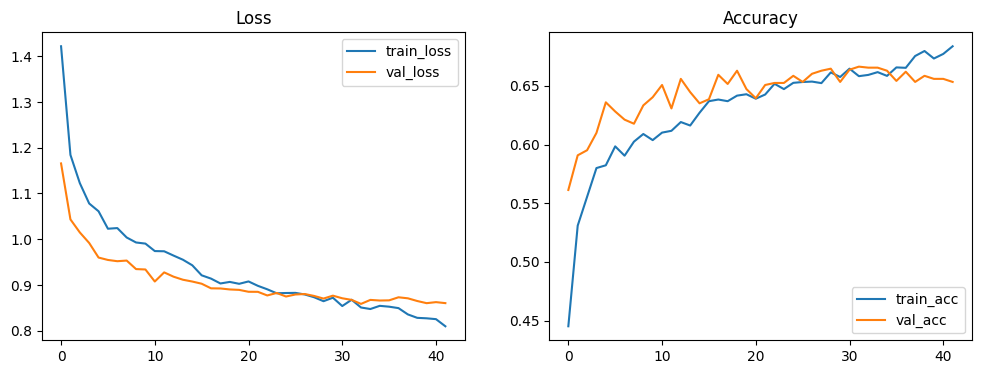

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.74      0.79      0.76       224
     disgust       0.71      0.57      0.63       223
       happy       0.71      0.62      0.66       224
     neutral       0.55      0.71      0.62       190
         sad       0.66      0.67      0.66       224
      scared       0.57      0.56      0.56       223

    accuracy                           0.65      1308
   macro avg       0.65      0.65      0.65      1308
weighted avg       0.66      0.65      0.65      1308



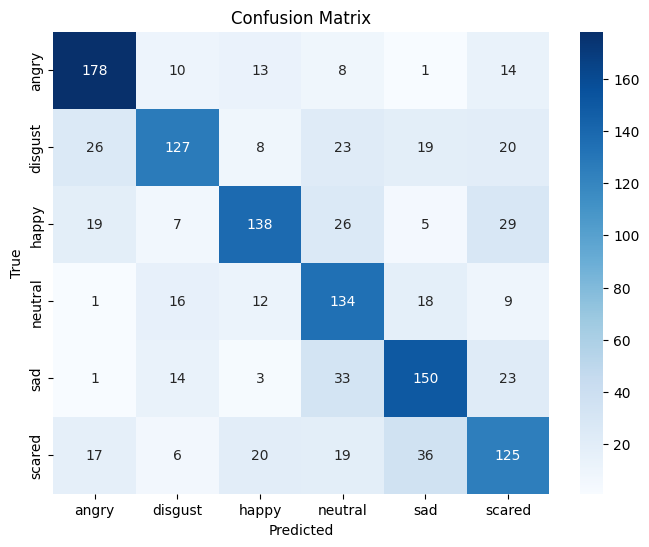

In [10]:
# ---------- Evaluate and visualize ----------

loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f'Test accuracy: {acc*100:.2f}%')

# Plot training
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()

# Confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [11]:
# ---------- Save artifacts: model & scaler & features ----------

# model already saved by checkpoint. Save scaler and label encoder using pickle
import pickle
with open('/content/drive/MyDrive/feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('/content/drive/MyDrive/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print('Saved scaler and label encoder to Drive.')

# features_df already saved earlier
print('All done.')

Saved scaler and label encoder to Drive.
All done.
